In [1]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import os
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv(dotenv_path="/home/jovyan/work/.env")

PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_SCHEMA_RAW = os.getenv("PG_SCHEMA_RAW")
PG_SCHEMA_ANALYTICS = os.getenv("PG_SCHEMA_ANALYTICS")


In [3]:
spark = SparkSession.builder \
    .appName("DataLoad") \
    .config("spark.jars", "/home/jovyan/work/jars/postgresql-42.7.3.jar") \
    .getOrCreate()

pgOptions = {
    "url": f"jdbc:postgresql://{PG_HOST}:{PG_PORT}/{PG_NAME}",
    "user": PG_USER,
    "password": PG_PASSWORD,
    "driver": "org.postgresql.Driver"
}



In [4]:
## Columnas para limpieza desde OBT

In [5]:
cols_keep = [
'vendor_name', 'trip_distance', 'passenger_count', 'rate_code_desc', 'total_amount', 'service_type', 'pickup_dow', 'pickup_month', 'pickup_year', 'pickup_hour', 'is_weekend', 'is_rush_hour', 'pickup_zone', 'pickup_borough'
]

In [6]:
## Prueba 1: Cargar muestras aleatorias

In [7]:
def load_sample(service, year, n=10000):
    query = f"""
        (SELECT {', '.join(cols_keep)} FROM analytics.obt_trips
         WHERE "service_type"='{service}' AND "pickup_year"={year}
         LIMIT {n}) AS tmp
    """
    return spark.read.jdbc(url=pgOptions["url"], table=query, properties=pgOptions)



In [8]:
print("Creando DataFrames de entrenamiento, validación y prueba...")
print("Creando 2016")
# 2016
df_2016_yellow = load_sample("yellow", 2016, n=250000)

print("Creando 2017")
# 2017
df_2017_yellow = load_sample("yellow", 2017, n=250000)

# Unir ambos años para train
df_train_yellow = df_2016_yellow.union(df_2017_yellow)


print("Creando 2018")
# 2018 validation
df_val_yellow = load_sample("yellow", 2018, n=250000)


print("Creando 2019")
# 2019 test
df_test_yellow = load_sample("yellow", 2019, n=250000)

print("DataFrames cargados desde Postgres: ")


Creando DataFrames de entrenamiento, validación y prueba...
Creando 2016
Creando 2017
Creando 2018
Creando 2019
DataFrames cargados desde Postgres: 


In [9]:
## Yellow

In [10]:
df_train_yellow = df_train_yellow.toPandas()
df_val_yellow = df_val_yellow.toPandas()
df_test_yellow = df_test_yellow.toPandas()


In [11]:
df_all_yellow = pd.concat([df_train_yellow, df_val_yellow, df_test_yellow], ignore_index=True)

In [12]:
#Cambiar los tipos de datos
columnas_a_convertir = ["trip_distance", "total_amount"] 

for col in columnas_a_convertir:
    df_all_yellow[col] = pd.to_numeric(df_all_yellow[col], errors='coerce').astype('float64')

In [13]:
#Conocer los datos
print(f"Shape: {df_all_yellow.shape}")
print(df_all_yellow.info())


Shape: (1000000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   vendor_name      997442 non-null   object 
 1   trip_distance    1000000 non-null  float64
 2   passenger_count  1000000 non-null  int32  
 3   rate_code_desc   1000000 non-null  object 
 4   total_amount     1000000 non-null  float64
 5   service_type     1000000 non-null  object 
 6   pickup_dow       1000000 non-null  int32  
 7   pickup_month     1000000 non-null  int32  
 8   pickup_year      1000000 non-null  int32  
 9   pickup_hour      1000000 non-null  int32  
 10  is_weekend       1000000 non-null  bool   
 11  is_rush_hour     1000000 non-null  bool   
 12  pickup_zone      1000000 non-null  object 
 13  pickup_borough   1000000 non-null  object 
dtypes: bool(2), float64(2), int32(5), object(5)
memory usage: 74.4+ MB
None


In [14]:
df_all_yellow.to_parquet(path="df_all_yellow.parquet", index=False)

In [15]:
#Conocimiento de nulos.
nulos = df_all_yellow.isnull().sum()
print(nulos[nulos > 0])
print(f"\nFilas duplicadas: {df_all_yellow.duplicated().sum()}")

vendor_name    2558
dtype: int64

Filas duplicadas: 5175


In [16]:
df_all_yellow[df_all_yellow['passenger_count'].isnull()]

,vendor_name,trip_distance,passenger_count,rate_code_desc,total_amount,service_type,pickup_dow,pickup_month,pickup_year,pickup_hour,is_weekend,is_rush_hour,pickup_zone,pickup_borough


In [17]:
df_all_yellow[df_all_yellow['vendor_name'].isnull()]

,vendor_name,trip_distance,passenger_count,rate_code_desc,total_amount,service_type,pickup_dow,pickup_month,pickup_year,pickup_hour,is_weekend,is_rush_hour,pickup_zone,pickup_borough
750029,None,0.94,1,Standard rate,10.56,yellow,6,1,2019,18,False,True,Upper West Side South,Manhattan
750083,None,0.50,1,Standard rate,6.80,yellow,6,1,2019,18,False,True,Flatiron,Manhattan
750123,None,0.36,1,Standard rate,7.56,yellow,6,1,2019,18,False,True,Upper West Side South,Manhattan
750159,None,0.89,1,Standard rate,8.80,yellow,6,1,2019,18,False,True,Lenox Hill West,Manhattan
750205,None,0.62,1,Standard rate,6.80,yellow,6,1,2019,18,False,True,Midtown South,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999107,None,1.03,1,Standard rate,10.14,yellow,2,1,2019,18,False,True,West Village,Manhattan
999202,None,0.64,1,Standard rate,7.56,yellow,2,1,2019,18,False,True,Midtown East,Manhattan
999206,None,2.24,1,Standard rate,15.38,yellow,2,1,2019,18,False,True,LaGuardia Airport,Queens
999729,None,0.51,1,Standard rate,8.16,yellow,2,1,2019,18,False,True,Midtown Center,Manhattan


In [18]:
df_all_yellow[df_all_yellow['rate_code_desc'].isnull()]

,vendor_name,trip_distance,passenger_count,rate_code_desc,total_amount,service_type,pickup_dow,pickup_month,pickup_year,pickup_hour,is_weekend,is_rush_hour,pickup_zone,pickup_borough


In [19]:
df_all_yellow['vendor_name'].value_counts()

vendor_name
Curb Mobility, LLC                   563010
Creative Mobile Technologies, LLC    434432
Name: count, dtype: int64

In [20]:
#Prueba 1.1: Eliminar nulos

In [21]:
df_all_yellow_dn = df_all_yellow.dropna()

In [22]:
df_all_yellow_dn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 997442 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   vendor_name      997442 non-null  object 
 1   trip_distance    997442 non-null  float64
 2   passenger_count  997442 non-null  int32  
 3   rate_code_desc   997442 non-null  object 
 4   total_amount     997442 non-null  float64
 5   service_type     997442 non-null  object 
 6   pickup_dow       997442 non-null  int32  
 7   pickup_month     997442 non-null  int32  
 8   pickup_year      997442 non-null  int32  
 9   pickup_hour      997442 non-null  int32  
 10  is_weekend       997442 non-null  bool   
 11  is_rush_hour     997442 non-null  bool   
 12  pickup_zone      997442 non-null  object 
 13  pickup_borough   997442 non-null  object 
dtypes: bool(2), float64(2), int32(5), object(5)
memory usage: 81.8+ MB


In [23]:
df_all_yellow_dn.to_parquet(path="df_all_yellow_dn.parquet", index=False)

In [24]:
df_all_yellow_dn = pd.read_parquet('df_all_yellow_dn.parquet')

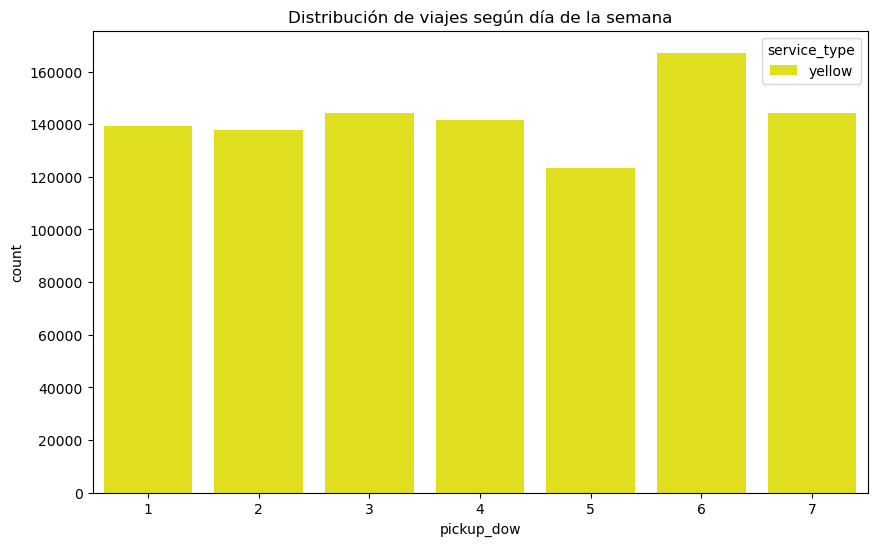

In [25]:
# ver la distribucion de viajes segun dia de la semana
plt.figure(figsize=(10, 6))
palette = {'green': 'green', 'yellow': 'yellow'}
sns.countplot(data=df_all_yellow_dn, x='pickup_dow', hue='service_type', palette=palette)
plt.title('Distribución de viajes según día de la semana')
plt.show()

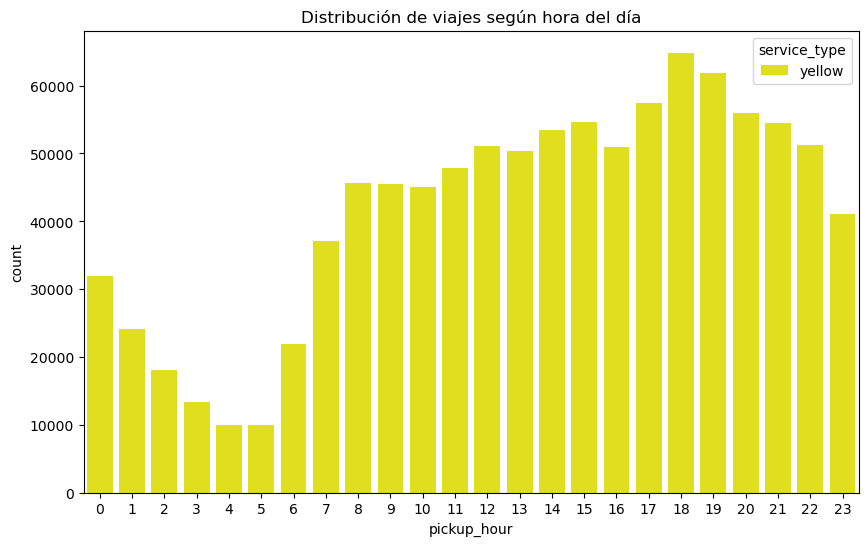

In [26]:
# ver distribucion de viajes segun hora del dia
plt.figure(figsize=(10, 6))
# poner una barra verde para green y amarilla para yellow
palette = {'green': 'green', 'yellow': 'yellow'}
sns.countplot(data=df_all_yellow_dn, x='pickup_hour', hue='service_type', palette=palette)
plt.title('Distribución de viajes según hora del día')
plt.show()

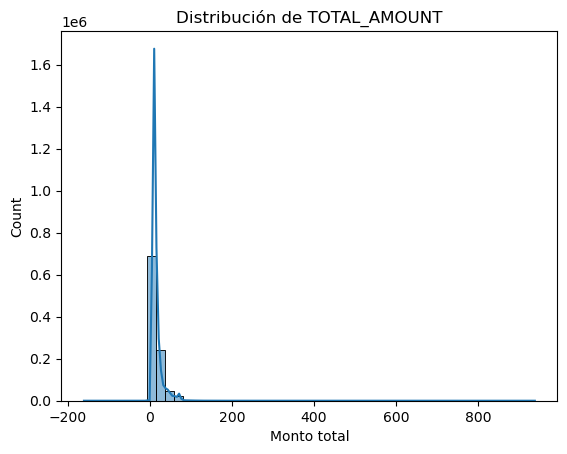

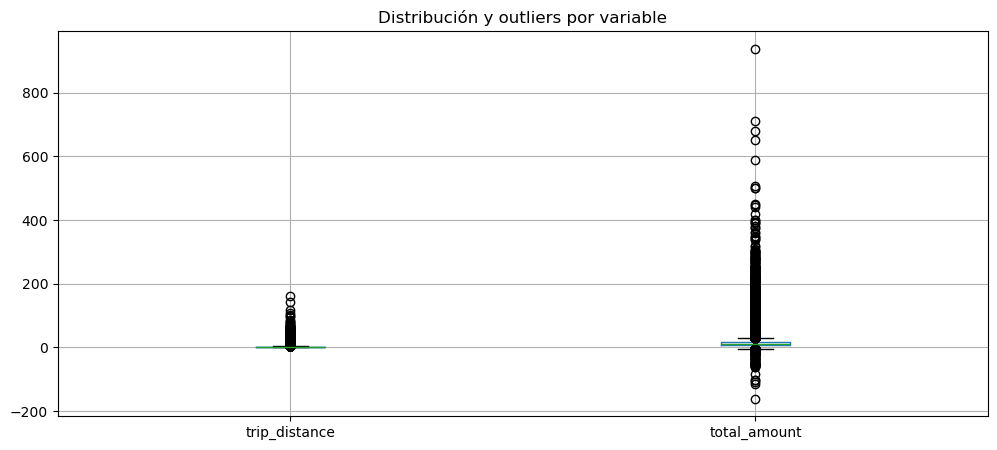

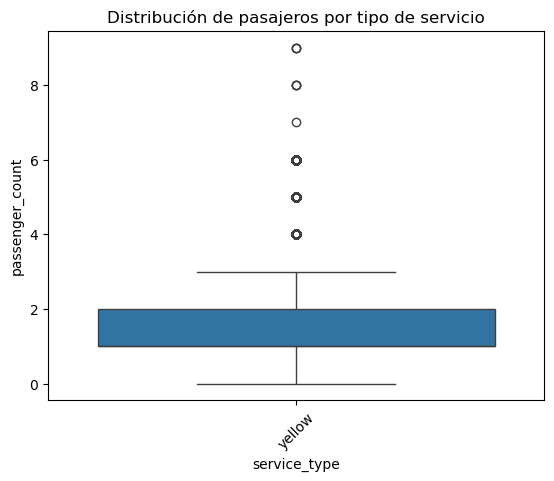

In [27]:
#Ver outliers 
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_all_yellow_dn["total_amount"], bins=50, kde=True)
plt.title("Distribución de TOTAL_AMOUNT")
plt.xlabel("Monto total")
plt.show()

plt.figure(figsize=(12, 5))
df_all_yellow_dn[['trip_distance', 'total_amount']].boxplot()
plt.title("Distribución y outliers por variable")
plt.show()

sns.boxplot(data=df_all_yellow_dn, x="service_type", y="passenger_count")
plt.title("Distribución de pasajeros por tipo de servicio")
plt.xticks(rotation=45)
plt.show()

In [29]:
#Descriptivas para outliners
df_all_yellow_dn.describe()


,trip_distance,passenger_count,total_amount,pickup_dow,pickup_month,pickup_year,pickup_hour
count,997442.000000,997442.000000,997442.000000,997442.000000,997442.0,997442.000000,997442.000000
mean,2.815759,1.619595,15.577780,4.052980,1.0,2017.496153,13.667982
std,3.626483,1.272802,13.610901,2.011547,0.0,1.116880,6.194655
min,0.000000,0.000000,-160.800000,1.000000,1.0,2016.000000,0.000000
25%,0.940000,1.000000,8.300000,2.000000,1.0,2016.000000,9.000000
50%,1.600000,1.000000,11.300000,4.000000,1.0,2017.000000,14.000000
75%,2.900000,2.000000,16.800000,6.000000,1.0,2018.000000,19.000000
max,160.520000,9.000000,938.390000,7.000000,1.0,2019.000000,23.000000


In [30]:
categorical = ['vendor_name', 'rate_code_desc','service_type','pickup_zone','pickup_borough']
for col in categorical:
    print(f"\n{col}:")
    print(df_all_yellow_dn[col].value_counts())


vendor_name:
vendor_name
Curb Mobility, LLC                   563010
Creative Mobile Technologies, LLC    434432
Name: count, dtype: int64

rate_code_desc:
rate_code_desc
Standard rate            970837
JFK                       20254
Negotiated fare            4194
Newark                     1624
Nassau or Westchester       507
Null/unknown                 16
Group ride                   10
Name: count, dtype: int64

service_type:
service_type
yellow    997442
Name: count, dtype: int64

pickup_zone:
pickup_zone
Upper East Side South                40123
Midtown Center                       38067
Upper East Side North                37903
Times Sq/Theatre District            34812
Midtown East                         34464
                                     ...  
Arden Heights                            1
New Dorp/Midland Beach                   1
Eltingville/Annadale/Prince's Bay        1
Broad Channel                            1
Willets Point                            1
Name: co

In [31]:
def clean_taxi_data_iqr(df, factor=1.5, min_price_per_mile=3.50):
    """
    Limpia datos usando el método IQR para detectar outliers
    factor: multiplicador del IQR (1.5 es estándar,3 ser más conservador)
    max_price_per_mile: umbral máximo de precio por milla para eliminar outliers
    min_price_per_mile: umbral mínimo de precio por milla para eliminar outliers
    """
    df_clean = df.copy()
    df_clean = df_clean.dropna()
    # Quitar 'N/A' y 'unknown' de pickup_borough
    df_clean = df_clean[(df_clean['pickup_borough'] != 'N/A') & (df_clean['pickup_borough'] != 'Unknown')]
    # Vendor name solo 1,2,6,7
    df_clean = df_clean[(df_clean['vendor_name'].isin(['Creative Mobile Technologies, LLC','Curb Mobility, LLC','Myle Technologies Inc','Helix']))]
    # Rate code desc solo 1 a 6
    df_clean = df_clean[(df_clean['rate_code_desc'].isin(['Standard rate','JFK','Newark',' Nassau or Westchester','Negotiated fare','Group ride','Null/unknown']))]
    df_clean = df_clean[(df_clean["passenger_count"] > 0) & (df_clean["passenger_count"] <= 6)] 

    # Primero eliminar valores imposibles
    df_clean = df_clean[(df_clean['trip_distance'] > 0)]
    df_clean = df_clean[(df_clean['total_amount'] > 3)]
    
    # eliminar outliers basados en precio por milla
    df_clean['price_per_mile'] = df_clean['total_amount'] / df_clean['trip_distance']
    df_clean = df_clean[(df_clean['price_per_mile'] >= min_price_per_mile)]

    # drop 'price_per_mile' column
    df_clean = df_clean.drop(columns=['price_per_mile'])
    
    # Limipar trip distance usando IQR
    Q1 = df_clean['trip_distance'].quantile(0.25)
    Q3 = df_clean['trip_distance'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df_clean = df_clean[(df_clean['trip_distance'] >= lower_bound) & (df_clean['trip_distance'] <= upper_bound)]

    # Limpiar total_amount usando IQR
    Q1 = df_clean['total_amount'].quantile(0.25)
    Q3 = df_clean['total_amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df_clean = df_clean[(df_clean['total_amount'] >= lower_bound) & (df_clean['total_amount'] <= upper_bound)]
    
    return df_clean

df_all_yellow_dn_clean = clean_taxi_data_iqr(df_all_yellow_dn, factor=3)


In [32]:
df_all_yellow_dn_clean

,vendor_name,trip_distance,passenger_count,rate_code_desc,total_amount,service_type,pickup_dow,pickup_month,pickup_year,pickup_hour,is_weekend,is_rush_hour,pickup_zone,pickup_borough
1,"Creative Mobile Technologies, LLC",1.00,1,Standard rate,6.30,yellow,6,1,2016,0,False,False,Stuy Town/Peter Cooper Village,Manhattan
2,"Curb Mobility, LLC",2.17,1,Standard rate,10.30,yellow,6,1,2016,0,False,False,Upper East Side North,Manhattan
3,"Curb Mobility, LLC",3.95,1,Standard rate,18.30,yellow,6,1,2016,0,False,False,Midtown North,Manhattan
4,"Curb Mobility, LLC",1.44,1,Standard rate,8.80,yellow,6,1,2016,0,False,False,Union Sq,Manhattan
5,"Curb Mobility, LLC",3.79,1,Standard rate,14.80,yellow,6,1,2016,0,False,False,Sutton Place/Turtle Bay North,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997437,"Creative Mobile Technologies, LLC",1.70,1,Standard rate,8.75,yellow,2,1,2019,18,False,True,Upper East Side South,Manhattan
997438,"Creative Mobile Technologies, LLC",1.00,2,Standard rate,8.16,yellow,2,1,2019,18,False,True,Lenox Hill West,Manhattan
997439,"Curb Mobility, LLC",1.32,2,Standard rate,8.80,yellow,2,1,2019,18,False,True,Times Sq/Theatre District,Manhattan
997440,"Creative Mobile Technologies, LLC",1.60,1,Standard rate,14.75,yellow,2,1,2019,18,False,True,Union Sq,Manhattan


In [33]:
#Categorical featuring

umbral = 1000
frecuencias_rate = df_all_yellow_dn_clean['rate_code_desc'].value_counts()

# Identificamos las categorías raras que están por debajo del umbral
categorias_raras_rate = frecuencias_rate[frecuencias_rate < umbral].index.tolist()

# --- 3. Remplazar categorías raras por 'Rare_Borough' ---
# Aplicamos el reemplazo de las raras directamente sobre la columna original.
df_all_yellow_dn_clean['rate_code_desc'].replace(
    categorias_raras_rate, 'Other', inplace=True
)

umbral_borough = 10000
frecuencias_borough = df_all_yellow_dn_clean['pickup_borough'].value_counts()

# Identificamos las categorías raras que están por debajo del umbral
categorias_raras_borough = frecuencias_borough[frecuencias_borough < umbral_borough].index.tolist()

# --- 3. Remplazar categorías raras por 'Rare_Borough' ---
# Aplicamos el reemplazo de las raras directamente sobre la columna original.
df_all_yellow_dn_clean['pickup_borough'].replace(
    categorias_raras_borough, 'Other', inplace=True
)

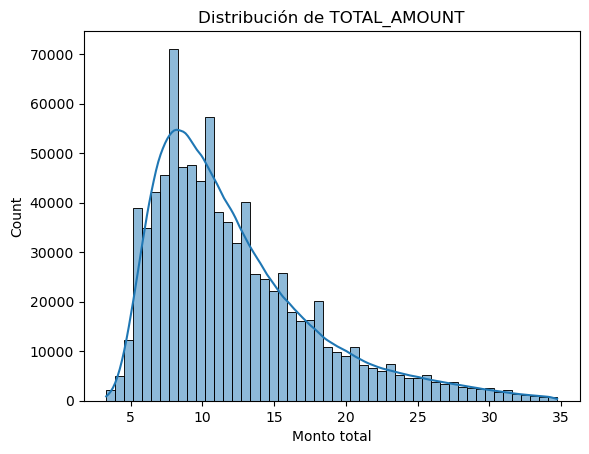

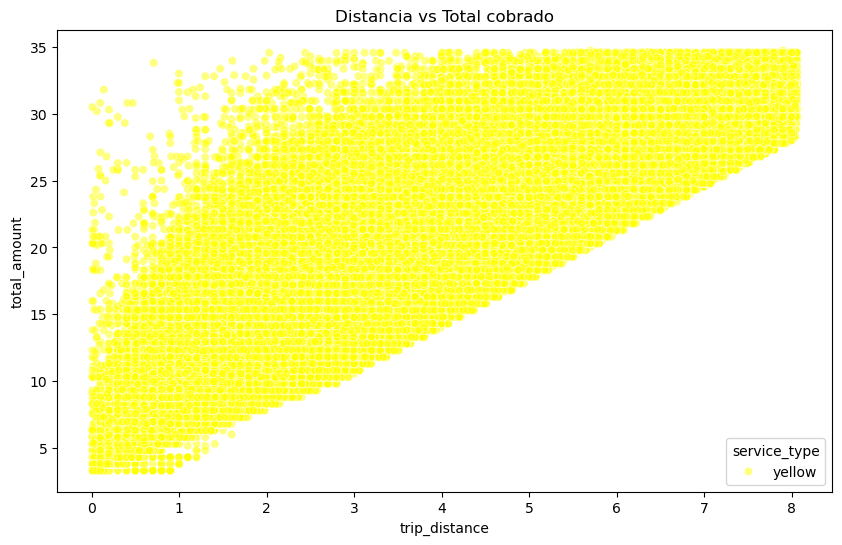

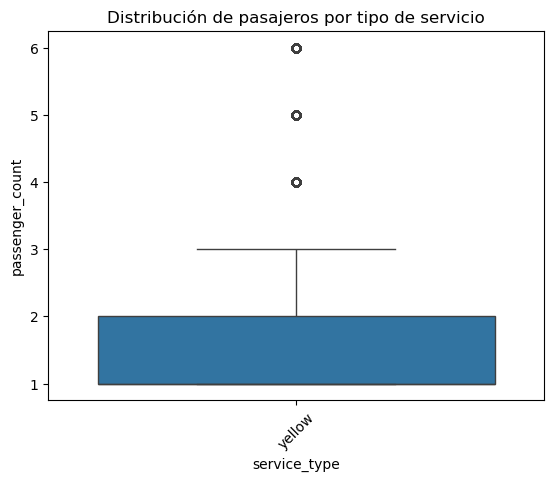

In [34]:
# graficar nuevamente
sns.histplot(df_all_yellow_dn_clean["total_amount"], bins=50, kde=True)
plt.title("Distribución de TOTAL_AMOUNT")
plt.xlabel("Monto total")
plt.show()

# poner yellow y green en scatterplot
plt.figure(figsize=(10, 6))
palette = {'green': 'green', 'yellow': 'yellow'}
sns.scatterplot(data=df_all_yellow_dn_clean, x="trip_distance", y="total_amount", alpha=0.5, hue="service_type", palette=palette)
plt.title("Distancia vs Total cobrado")
plt.show()

sns.boxplot(data=df_all_yellow_dn_clean, x="service_type", y="passenger_count")
plt.title("Distribución de pasajeros por tipo de servicio")
plt.xticks(rotation=45)
plt.show()

In [35]:
df_all_yellow_dn_clean = df_all_yellow_dn_clean.drop(columns=['trip_distance','service_type','pickup_zone'])
df_all_yellow_dn_clean.to_parquet(path="df_all_yellow_dn_clean.parquet", index=False)